<a href="https://colab.research.google.com/github/samsonroni-14/AmazonEDA/blob/main/Tourism_Analytics_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tourism Experience Analytics
## Data Cleaning, Preprocessing & Exploratory Data Analysis

**Objective:** Analyze tourism data to build classification (VisitMode prediction), regression (Rating prediction), and recommendation systems.

### Datasets:
- **Transaction** (52,930 rows): User visits, ratings, visit mode
- **User** (33,530 rows): User demographics
- **City, Country, Region, Continent**: Geographic lookups
- **Updated_Item** (1,698 rows): Attraction details
- **Mode, Type**: Category lookups

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_squared_error, r2_score)
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
PALETTE = 'Set2'
sns.set_palette(PALETTE)

print('All libraries imported successfully!')

All libraries imported successfully!


---
## 2. Load All Datasets

In [2]:
DATA_PATH = './'

transaction  = pd.read_excel(DATA_PATH + 'Transaction.xlsx')
user         = pd.read_excel(DATA_PATH + 'User.xlsx')
city         = pd.read_excel(DATA_PATH + 'City.xlsx')
continent    = pd.read_excel(DATA_PATH + 'Continent.xlsx')
country      = pd.read_excel(DATA_PATH + 'Country.xlsx')
region       = pd.read_excel(DATA_PATH + 'Region.xlsx')
item         = pd.read_excel(DATA_PATH + 'Updated_Item.xlsx')  # Used Updated_Item (1698 attractions)
mode         = pd.read_excel(DATA_PATH + 'Mode.xlsx')
atype        = pd.read_excel(DATA_PATH + 'Type.xlsx')

print('Dataset Shapes:')
for name, df in [('Transaction', transaction), ('User', user), ('City', city),
                 ('Continent', continent), ('Country', country), ('Region', region),
                 ('Item (Updated)', item), ('Mode', mode), ('Type', atype)]:
    print(f'  {name:<20}: {df.shape}')

Dataset Shapes:
  Transaction         : (52930, 7)
  User                : (33530, 5)
  City                : (9143, 3)
  Continent           : (6, 2)
  Country             : (165, 3)
  Region              : (22, 3)
  Item (Updated)      : (1698, 5)
  Mode                : (6, 2)
  Type                : (17, 2)


---
## 3. Data Cleaning
### 3.1 Missing Values Check

In [3]:
print('=== Missing Values Summary ===')
for name, df in [('Transaction', transaction), ('User', user), ('City', city),
                 ('Item', item), ('Country', country), ('Region', region)]:
    nulls = df.isnull().sum()
    if nulls.sum() > 0:
        print(f'\n{name}:')
        print(nulls[nulls > 0])
    else:
        print(f'{name}: No missing values')

=== Missing Values Summary ===
Transaction: No missing values

User:
CityId    4
dtype: int64

City:
CityName    1
dtype: int64
Item: No missing values
Country: No missing values
Region: No missing values


In [4]:
# Handle missing values in Item dataset (AttractionAddress is missing)
item['AttractionAddress'].fillna('Unknown', inplace=True)

# Handle any missing in User
user.dropna(inplace=True)

print('Missing values handled.')

Missing values handled.


### 3.2 Duplicates Check

In [5]:
for name, df in [('Transaction', transaction), ('User', user)]:
    dups = df.duplicated().sum()
    print(f'{name} duplicates: {dups}')

transaction.drop_duplicates(inplace=True)
user.drop_duplicates(inplace=True)
print('\nDuplicates removed.')
print(f'Transaction rows after: {len(transaction)}')

Transaction duplicates: 0
User duplicates: 0

Duplicates removed.
Transaction rows after: 52930


### 3.3 Validate Data Ranges

In [6]:
# Rating should be 1-5
print('Rating range:', transaction['Rating'].min(), '-', transaction['Rating'].max())
print('Rating unique values:', sorted(transaction['Rating'].unique()))

# VisitYear
print('\nVisitYear range:', transaction['VisitYear'].min(), '-', transaction['VisitYear'].max())

# VisitMonth
print('VisitMonth range:', transaction['VisitMonth'].min(), '-', transaction['VisitMonth'].max())

# Filter out invalid ratings
transaction = transaction[(transaction['Rating'] >= 1) & (transaction['Rating'] <= 5)]
transaction = transaction[(transaction['VisitMonth'] >= 1) & (transaction['VisitMonth'] <= 12)]

print('\nData ranges validated.')

Rating range: 1 - 5
Rating unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

VisitYear range: 2013 - 2022
VisitMonth range: 1 - 12

Data ranges validated.


---
## 4. Data Preprocessing
### 4.1 Merge All Tables into Master Dataset

In [7]:
# Step 1: Transaction + User
df = transaction.merge(user, on='UserId', how='left')

# Step 2: Add Continent
df = df.merge(continent, on='ContinentId', how='left')

# Step 3: Add Region
df = df.merge(region[['RegionId', 'Region']], on='RegionId', how='left')

# Step 4: Add Country
df = df.merge(country[['CountryId', 'Country']], on='CountryId', how='left')

# Step 5: Add City
df = df.merge(city[['CityId', 'CityName']], on='CityId', how='left')

# Step 6: Add Attraction (Updated_Item)
item_cols = item[['AttractionId', 'AttractionCityId', 'AttractionTypeId', 'Attraction']]
df = df.merge(item_cols, on='AttractionId', how='left')

# Step 7: Add Attraction Type name
df = df.merge(atype, on='AttractionTypeId', how='left')

# Step 8: Add VisitMode name
df = df.merge(mode, left_on='VisitMode', right_on='VisitModeId', how='left')
df.rename(columns={'VisitMode_y': 'VisitModeName', 'VisitMode_x': 'VisitModeId'}, inplace=True)

print('Master DataFrame shape:', df.shape)
print('Columns:', list(df.columns))
df.head(3)

Master DataFrame shape: (52930, 21)
Columns: ['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitModeId', 'AttractionId', 'Rating', 'ContinentId', 'RegionId', 'CountryId', 'CityId', 'Continent', 'Region', 'Country', 'CityName', 'AttractionCityId', 'AttractionTypeId', 'Attraction', 'AttractionType', 'VisitModeId', 'VisitModeName']


,TransactionId,UserId,VisitYear,VisitMonth,VisitModeId,AttractionId,Rating,ContinentId,RegionId,CountryId,...,Continent,Region,Country,CityName,AttractionCityId,AttractionTypeId,Attraction,AttractionType,VisitModeId,VisitModeName
0,3,70456,2022,10,2,640,5,5.0,21.0,163.0,...,Europe,Western Europe,United Kingdom,Guildford,1,63,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,2,Couples
1,8,7567,2022,10,4,640,5,2.0,8.0,48.0,...,America,Northern America,Canada,Ontario,1,63,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,4,Friends
2,9,79069,2022,10,3,640,5,2.0,9.0,54.0,...,America,South America,Brazil,Brazil,1,63,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,3,Family


### 4.2 Feature Engineering

In [8]:
# Season from month
def get_season(month):
    if month in [12, 1, 2]:   return 'Winter'
    elif month in [3, 4, 5]:   return 'Spring'
    elif month in [6, 7, 8]:   return 'Summer'
    else:                      return 'Autumn'

df['Season'] = df['VisitMonth'].apply(get_season)

# Average rating per attraction (from historical data)
avg_rating = df.groupby('AttractionId')['Rating'].mean().rename('AvgAttractionRating')
df = df.merge(avg_rating, on='AttractionId', how='left')

# Visit count per attraction (popularity)
visit_count = df.groupby('AttractionId')['TransactionId'].count().rename('AttractionVisitCount')
df = df.merge(visit_count, on='AttractionId', how='left')

# User's historical average rating
user_avg = df.groupby('UserId')['Rating'].mean().rename('UserAvgRating')
df = df.merge(user_avg, on='UserId', how='left')

print('Feature engineering done. New shape:', df.shape)
df[['Season', 'AvgAttractionRating', 'AttractionVisitCount', 'UserAvgRating']].head()

Feature engineering done. New shape: (52930, 25)


,Season,AvgAttractionRating,AttractionVisitCount,UserAvgRating
0,Autumn,4.267086,13198,5.0
1,Autumn,4.267086,13198,5.0
2,Autumn,4.267086,13198,5.0
3,Autumn,4.267086,13198,3.0
4,Autumn,4.267086,13198,3.0


### 4.3 Encoding Categorical Variables

In [9]:
# Encode categorical features for ML
cat_cols = ['Continent', 'Region', 'Country', 'Season', 'AttractionType']
le_dict = {}

df_ml = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_ml[col + '_enc'] = le.fit_transform(df_ml[col].astype(str))
    le_dict[col] = le

print('Encoded columns:', [c + '_enc' for c in cat_cols])
print('\nExample — Continent encoding:')
print(dict(zip(le_dict['Continent'].classes_, le_dict['Continent'].transform(le_dict['Continent'].classes_))))

Encoded columns: ['Continent_enc', 'Region_enc', 'Country_enc', 'Season_enc', 'AttractionType_enc']

Example — Continent encoding:
{'Africa': np.int64(0), 'America': np.int64(1), 'Asia': np.int64(2), 'Australia & Oceania': np.int64(3), 'Europe': np.int64(4), 'nan': np.int64(5)}


### 4.4 Save Cleaned Master Dataset

In [10]:
df.to_csv('tourism_master_cleaned.csv', index=False)
print('Saved: tourism_master_cleaned.csv')
print('Final shape:', df.shape)
df.describe()

Saved: tourism_master_cleaned.csv
Final shape: (52930, 25)


,TransactionId,UserId,VisitYear,VisitMonth,VisitModeId,AttractionId,Rating,ContinentId,RegionId,CountryId,CityId,AttractionCityId,VisitModeId,AvgAttractionRating,AttractionVisitCount,UserAvgRating
count,52930.000000,52930.000000,52930.000000,52930.000000,52930.000000,52930.000000,52930.000000,52922.000000,52922.000000,52922.000000,52922.000000,52930.000000,52930.000000,52930.000000,52930.000000,52930.000000
mean,70415.130474,45024.522596,2016.351899,6.633100,2.945759,759.663782,4.157699,3.592816,14.524470,106.297589,3398.125373,1.277555,2.945759,4.157699,5960.499112,4.157699
std,66299.514206,25073.062199,1.732926,3.392979,1.000683,210.716111,0.970543,1.075385,4.186383,35.736586,2326.073352,0.680015,1.000683,0.293003,4486.579372,0.828686
min,3.000000,14.000000,2013.000000,1.000000,1.000000,369.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.415190,28.000000,1.000000
25%,19646.250000,23470.000000,2015.000000,4.000000,2.000000,640.000000,4.000000,3.000000,13.000000,93.000000,1434.000000,1.000000,2.000000,3.976347,2765.000000,4.000000
50%,42770.500000,45533.500000,2016.000000,7.000000,3.000000,737.000000,4.000000,4.000000,15.000000,109.000000,3156.000000,1.000000,3.000000,4.219411,3359.000000,4.050000
75%,105638.750000,66667.000000,2018.000000,9.000000,4.000000,841.000000,5.000000,5.000000,17.000000,121.000000,4940.000000,1.000000,4.000000,4.267086,6429.000000,5.000000
max,211241.000000,88190.000000,2022.000000,12.000000,5.000000,1297.000000,5.000000,5.000000,21.000000,164.000000,9142.000000,3.000000,5.000000,4.698795,13198.000000,5.000000


---
## 5. Exploratory Data Analysis (EDA)
### 5.1 Rating Distribution

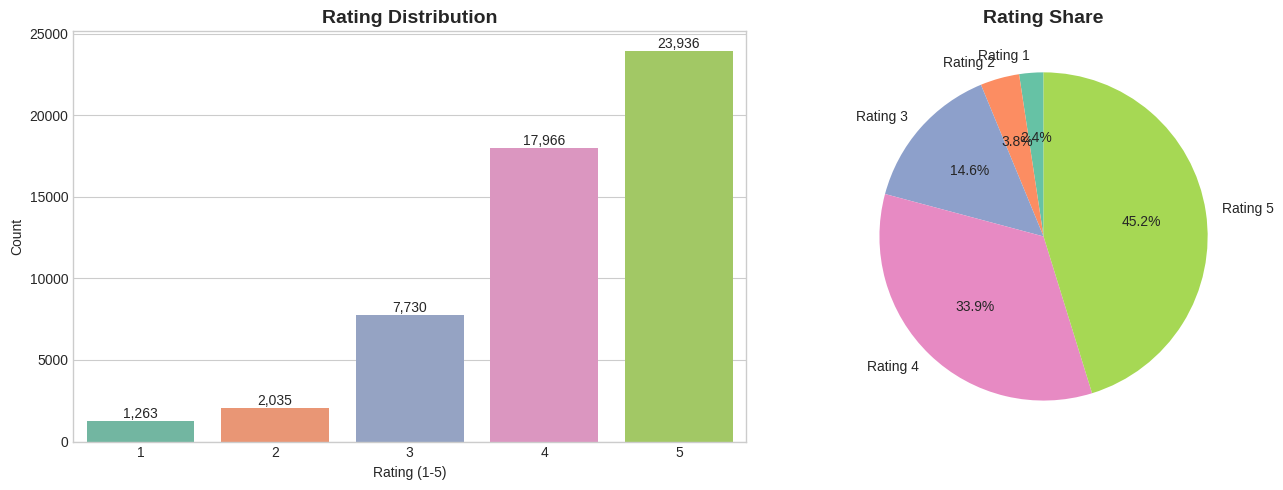


Rating stats:
count    52930.000000
mean         4.157699
std          0.970543
min          1.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating count
sns.countplot(data=df, x='Rating', palette='Set2', ax=axes[0])
axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating (1-5)')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=10)

# Pie chart
rating_counts = df['Rating'].value_counts().sort_index()
axes[1].pie(rating_counts, labels=[f'Rating {i}' for i in rating_counts.index],
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', 5))
axes[1].set_title('Rating Share', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_rating_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nRating stats:')
print(df['Rating'].describe())

### 5.2 Visit Mode Distribution

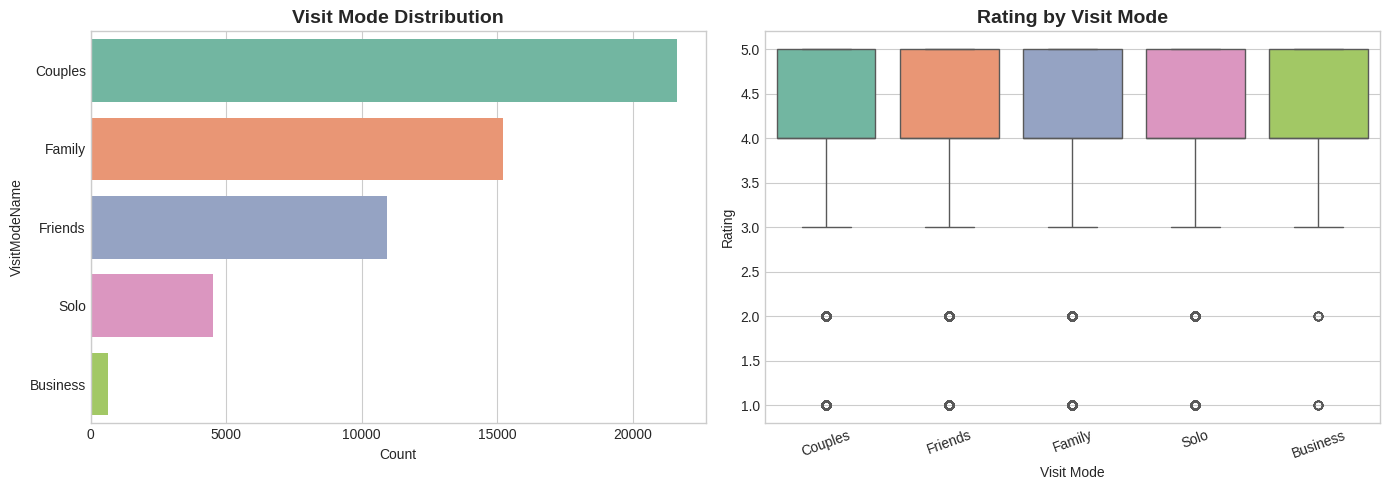

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mode_counts = df['VisitModeName'].value_counts()

# Bar
sns.barplot(x=mode_counts.values, y=mode_counts.index, palette='Set2', ax=axes[0])
axes[0].set_title('Visit Mode Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')

# Rating by Visit Mode
sns.boxplot(data=df, x='VisitModeName', y='Rating', palette='Set2', ax=axes[1])
axes[1].set_title('Rating by Visit Mode', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Visit Mode')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('eda_visitmode.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Geographic Distribution

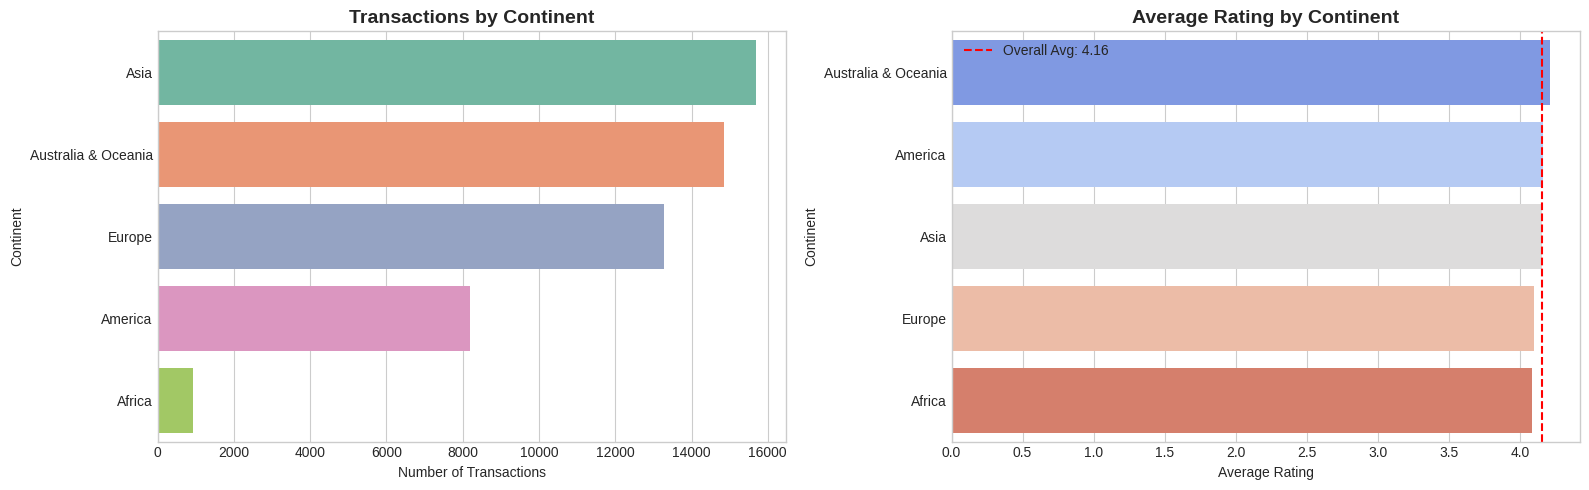

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Users by Continent
cont_counts = df['Continent'].value_counts()
sns.barplot(x=cont_counts.values, y=cont_counts.index, palette='Set2', ax=axes[0])
axes[0].set_title('Transactions by Continent', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Transactions')

# Average Rating by Continent
cont_rating = df.groupby('Continent')['Rating'].mean().sort_values(ascending=False)
sns.barplot(x=cont_rating.values, y=cont_rating.index, palette='coolwarm', ax=axes[1])
axes[1].set_title('Average Rating by Continent', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Rating')
axes[1].axvline(df['Rating'].mean(), color='red', linestyle='--', label=f'Overall Avg: {df["Rating"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('eda_geographic.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Temporal Trends

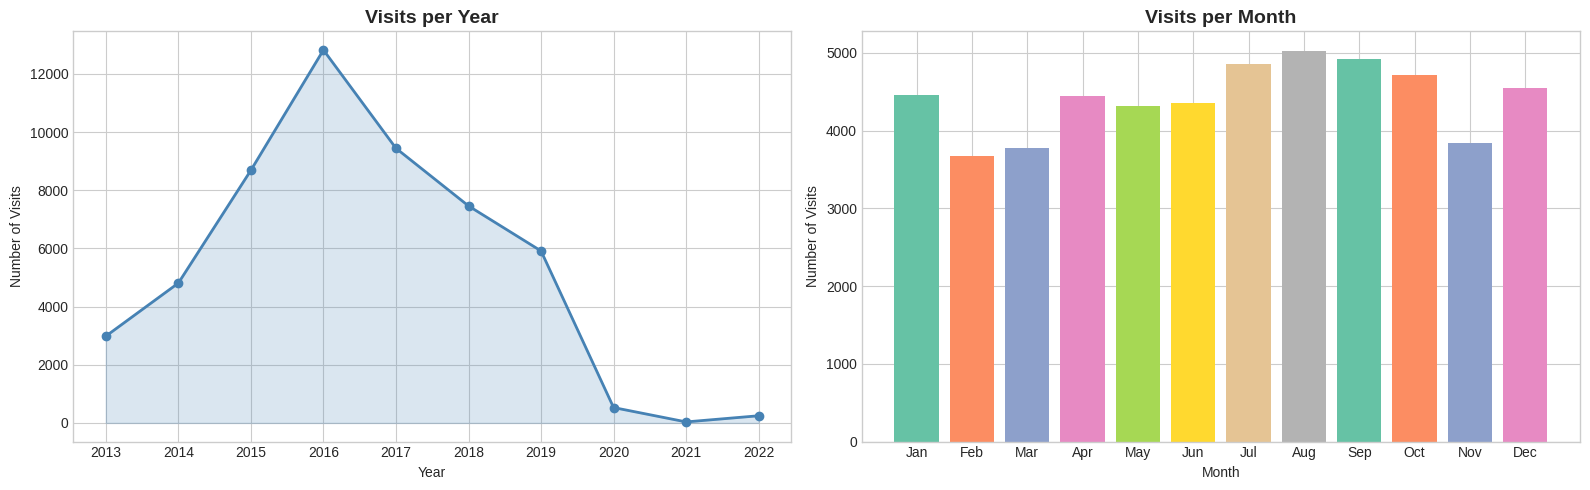

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Visits per Year
year_counts = df['VisitYear'].value_counts().sort_index()
axes[0].plot(year_counts.index, year_counts.values, 'o-', color='steelblue', linewidth=2, markersize=6)
axes[0].fill_between(year_counts.index, year_counts.values, alpha=0.2, color='steelblue')
axes[0].set_title('Visits per Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Visits')
axes[0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Visits per Month
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_counts = df['VisitMonth'].value_counts().sort_index()
axes[1].bar(month_counts.index, month_counts.values, color=sns.color_palette('Set2', 12))
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_labels)
axes[1].set_title('Visits per Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Visits')

plt.tight_layout()
plt.savefig('eda_temporal.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.5 Attraction Type Analysis

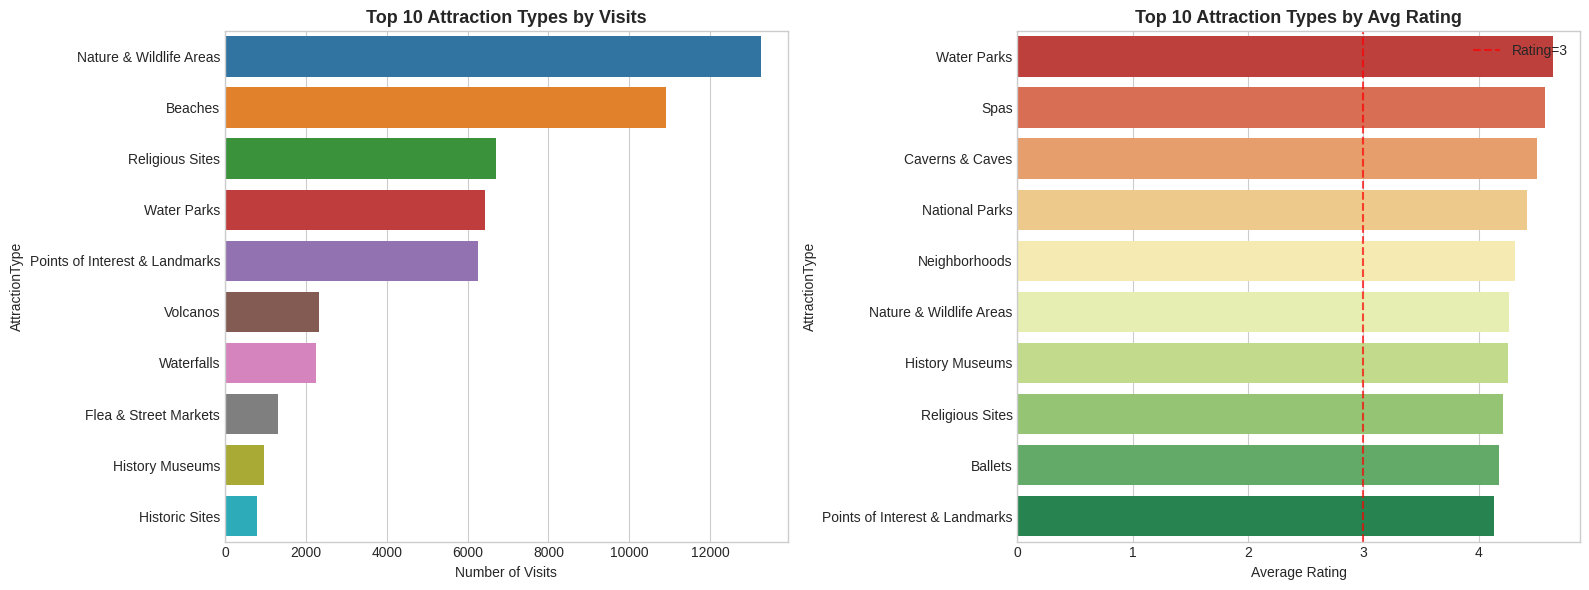

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top attraction types by visits
type_counts = df['AttractionType'].value_counts().head(10)
sns.barplot(x=type_counts.values, y=type_counts.index, palette='tab10', ax=axes[0])
axes[0].set_title('Top 10 Attraction Types by Visits', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Visits')

# Average rating per attraction type
type_rating = df.groupby('AttractionType')['Rating'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=type_rating.values, y=type_rating.index, palette='RdYlGn', ax=axes[1])
axes[1].set_title('Top 10 Attraction Types by Avg Rating', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Average Rating')
axes[1].axvline(3, color='red', linestyle='--', alpha=0.7, label='Rating=3')
axes[1].legend()

plt.tight_layout()
plt.savefig('eda_attraction_types.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.6 Correlation Heatmap

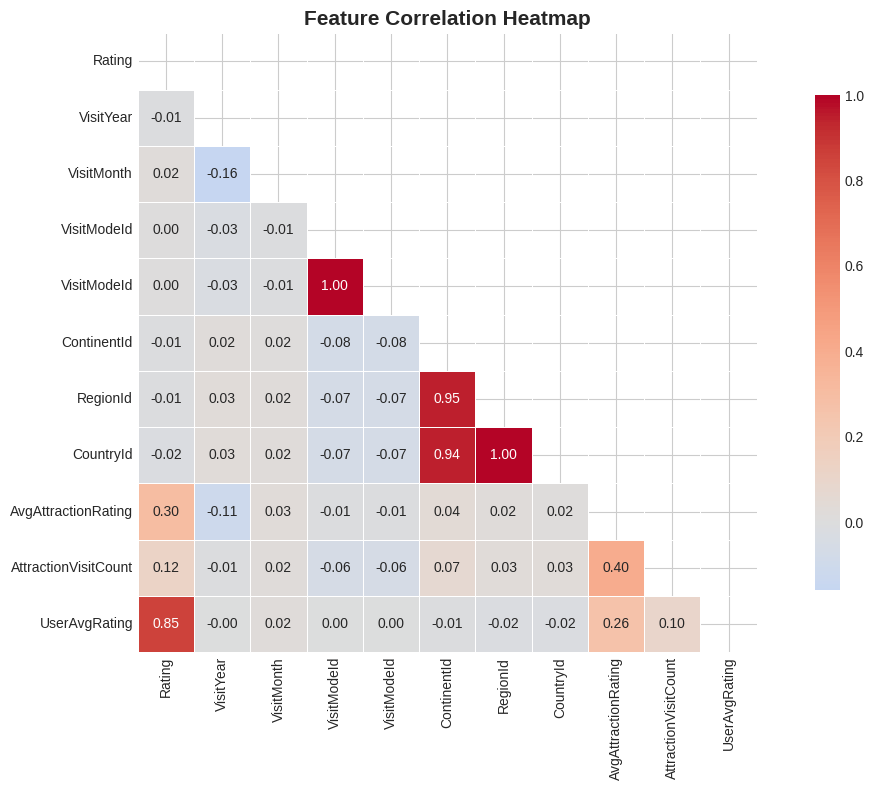

In [16]:
num_cols = ['Rating', 'VisitYear', 'VisitMonth', 'VisitModeId',
            'ContinentId', 'RegionId', 'CountryId',
            'AvgAttractionRating', 'AttractionVisitCount', 'UserAvgRating']

corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.7 Season vs Rating vs Visit Mode

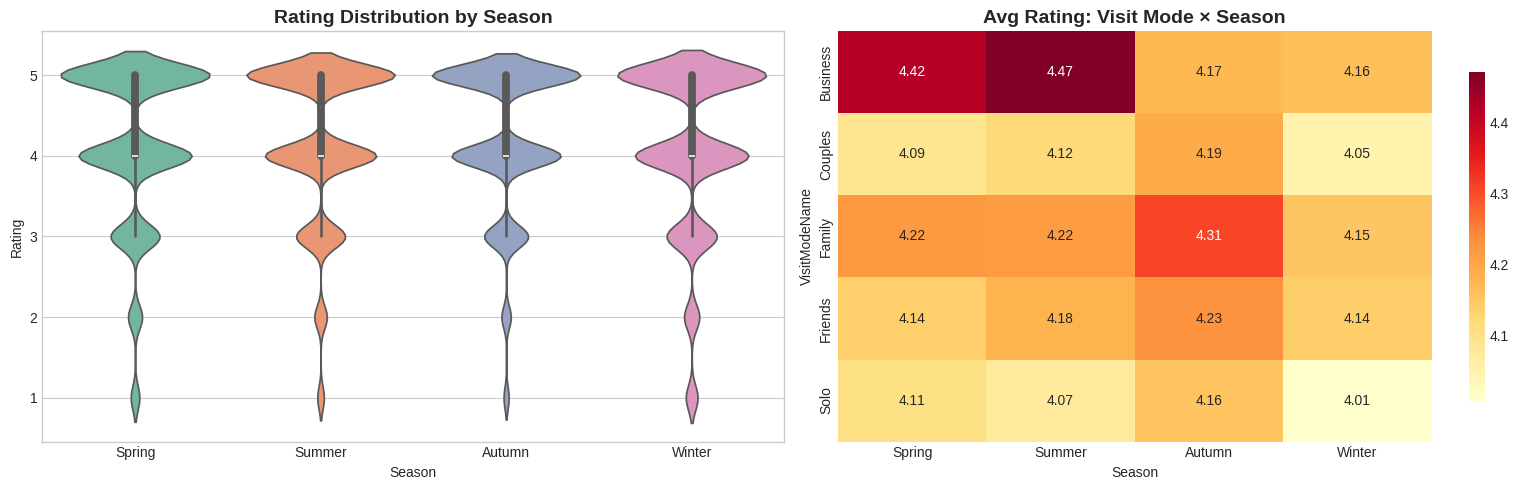

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Season vs Rating
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
sns.violinplot(data=df, x='Season', y='Rating', order=season_order, palette='Set2', ax=axes[0])
axes[0].set_title('Rating Distribution by Season', fontsize=14, fontweight='bold')

# Heatmap: Visit Mode vs Season
pivot = df.groupby(['VisitModeName', 'Season'])['Rating'].mean().unstack()
pivot = pivot[season_order]
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Avg Rating: Visit Mode × Season', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_season_mode.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.8 Top 10 Most Visited Attractions

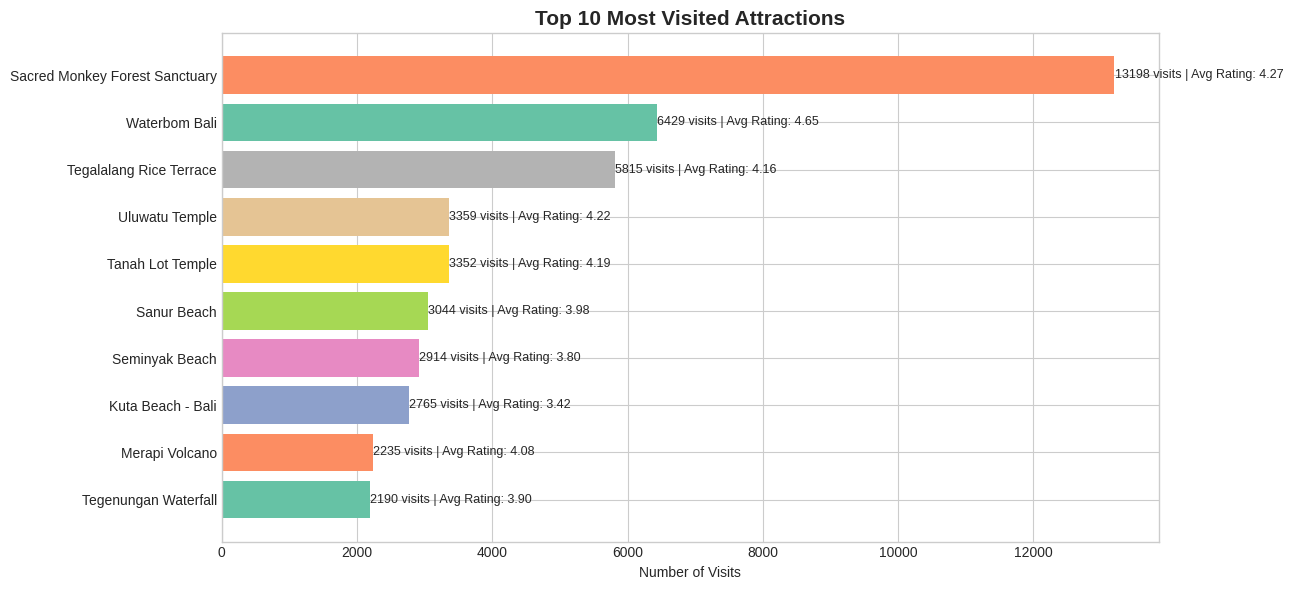

                                Visits  AvgRating
Attraction                                       
Sacred Monkey Forest Sanctuary   13198   4.267086
Waterbom Bali                     6429   4.646601
Tegalalang Rice Terrace           5815   4.157524
Uluwatu Temple                    3359   4.219411
Tanah Lot Temple                  3352   4.194809
Sanur Beach                       3044   3.976347
Seminyak Beach                    2914   3.800618
Kuta Beach - Bali                 2765   3.415190
Merapi Volcano                    2235   4.079195
Tegenungan Waterfall              2190   3.895434


In [18]:
top_attractions = df.groupby('Attraction').agg(
    Visits=('TransactionId', 'count'),
    AvgRating=('Rating', 'mean')
).sort_values('Visits', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 6))
bars = ax.barh(top_attractions.index[::-1], top_attractions['Visits'][::-1],
               color=sns.color_palette('Set2', 10))

for i, (v, r) in enumerate(zip(top_attractions['Visits'][::-1], top_attractions['AvgRating'][::-1])):
    ax.text(v + 5, i, f'{v} visits | Avg Rating: {r:.2f}', va='center', fontsize=9)

ax.set_title('Top 10 Most Visited Attractions', fontsize=15, fontweight='bold')
ax.set_xlabel('Number of Visits')
plt.tight_layout()
plt.savefig('eda_top_attractions.png', dpi=150, bbox_inches='tight')
plt.show()

print(top_attractions)

---
## 6. Model Building
### 6.1 Prepare ML Features

In [27]:
FEATURES = ['ContinentId', 'RegionId', 'CountryId', 'CityId',
            'VisitYear', 'VisitMonth', 'AttractionId', 'AttractionTypeId',
            'AvgAttractionRating', 'AttractionVisitCount', 'UserAvgRating']

# Fix: use VisitModeName (clean string) instead of VisitModeId to avoid multioutput error
ml_df = df[FEATURES + ['Rating', 'VisitModeName']].dropna()
ml_df = ml_df[ml_df['VisitModeName'].apply(lambda x: isinstance(x, str))]

print('ML dataset shape:', ml_df.shape)
print('VisitModeName classes:', ml_df['VisitModeName'].unique())

X        = ml_df[FEATURES]
y_rating = ml_df['Rating']         # Regression target
y_mode   = ml_df['VisitModeName']  # Classification target ← changed from VisitModeId

X_train, X_test, yr_train, yr_test, ym_train, ym_test = train_test_split(
    X, y_rating, y_mode, test_size=0.2, random_state=42
)

print(f'Train: {X_train.shape[0]} | Test: {X_test.shape[0]}')

ML dataset shape: (52922, 13)
VisitModeName classes: ['Couples' 'Friends' 'Family' 'Solo' 'Business']
Train: 42337 | Test: 10585


### 6.2 Regression: Predict Rating

=== Regression Results (Random Forest) ===
R²  : 0.6741
MSE : 0.3097
RMSE: 0.5565


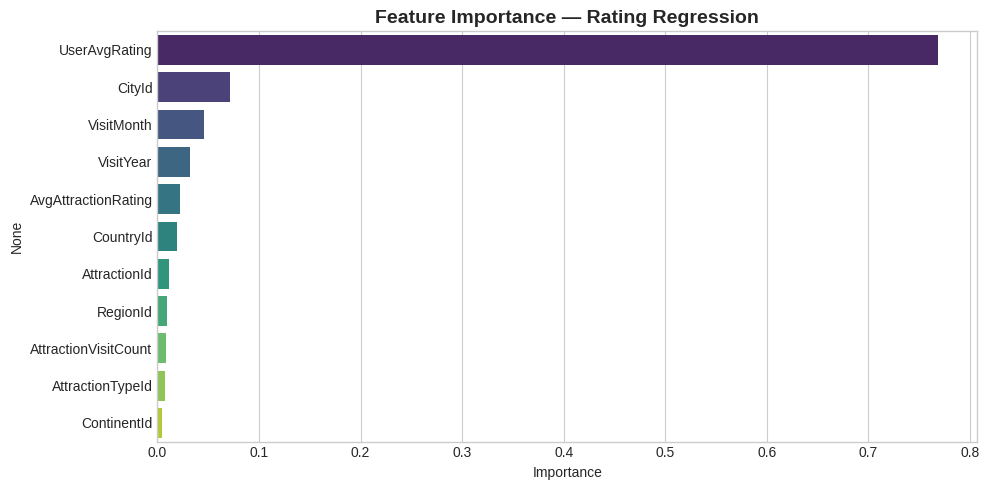

In [28]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, yr_train)
yr_pred = rf_reg.predict(X_test)

r2  = r2_score(yr_test, yr_pred)
mse = mean_squared_error(yr_test, yr_pred)
rmse = np.sqrt(mse)

print('=== Regression Results (Random Forest) ===')
print(f'R²  : {r2:.4f}')
print(f'MSE : {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

# Feature importance
feat_imp = pd.Series(rf_reg.feature_importances_, index=FEATURES).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Feature Importance — Rating Regression', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('model_reg_importance.png', dpi=150, bbox_inches='tight')
plt.show()

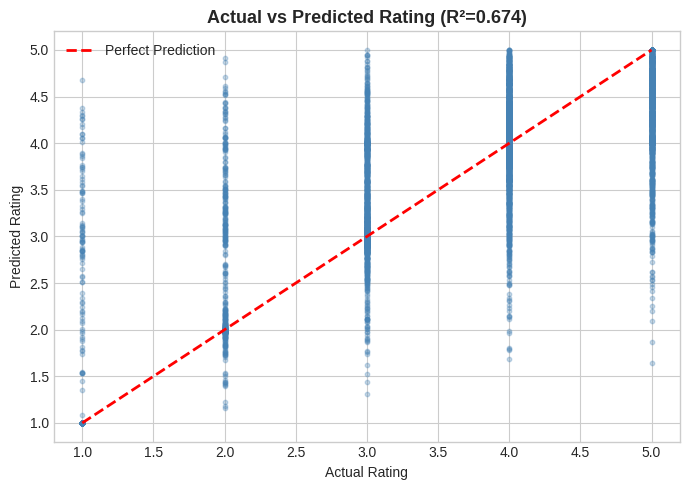

In [29]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(yr_test, yr_pred, alpha=0.3, s=10, color='steelblue')
plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title(f'Actual vs Predicted Rating (R²={r2:.3f})', fontsize=13, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('model_reg_actual_vs_pred.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Classification: Predict Visit Mode

In [30]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, ym_train)
ym_pred = rf_clf.predict(X_test)

acc = accuracy_score(ym_test, ym_pred)
print('=== Classification Results (Random Forest) ===')
print(f'Accuracy: {acc:.4f}\n')
print(classification_report(ym_test, ym_pred,
      target_names=[str(m) for m in sorted(ym_test.unique())]))

=== Classification Results (Random Forest) ===
Accuracy: 0.4981

              precision    recall  f1-score   support

    Business       0.49      0.25      0.33       135
     Couples       0.53      0.68      0.60      4337
      Family       0.50      0.48      0.49      2995
     Friends       0.40      0.30      0.34      2190
        Solo       0.41      0.22      0.29       928

    accuracy                           0.50     10585
   macro avg       0.47      0.39      0.41     10585
weighted avg       0.49      0.50      0.48     10585



In [31]:
# Also try Gradient Boosting for comparison
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, ym_train)
ym_pred_gb = gb_clf.predict(X_test)
acc_gb = accuracy_score(ym_test, ym_pred_gb)
print(f'Gradient Boosting Accuracy: {acc_gb:.4f}')
print('\nModel Comparison:')
print(f'  Random Forest : {acc:.4f}')
print(f'  Gradient Boost: {acc_gb:.4f}')

Gradient Boosting Accuracy: 0.4808

Model Comparison:
  Random Forest : 0.4981
  Gradient Boost: 0.4808


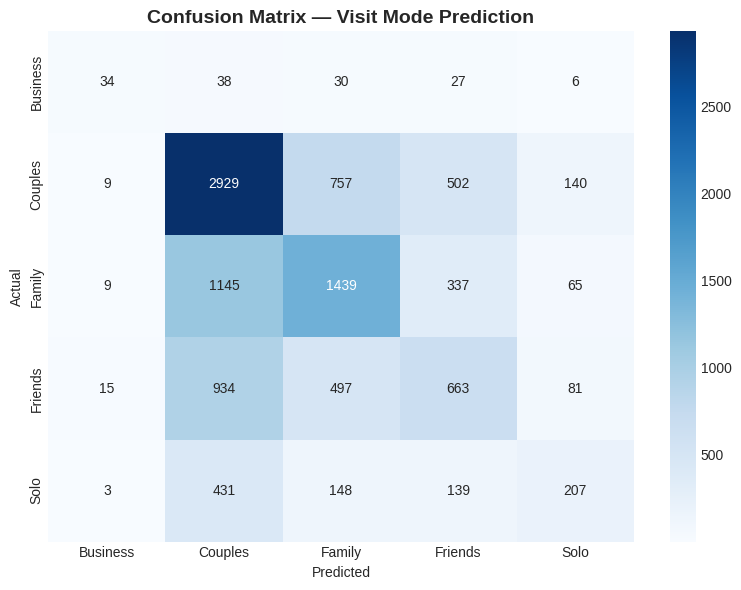

In [32]:
# Confusion matrix — labels are now strings directly
cm = confusion_matrix(ym_test, ym_pred)
class_names = sorted(ym_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix — Visit Mode Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('model_clf_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.4 Recommendation System (Collaborative Filtering)

In [33]:
# Build user-item rating matrix
# Use a sample for memory efficiency
sample_users = df['UserId'].value_counts().head(500).index
rec_df = df[df['UserId'].isin(sample_users)]

user_item_matrix = rec_df.pivot_table(
    index='UserId', columns='AttractionId', values='Rating', aggfunc='mean'
).fillna(0)

print('User-Item matrix shape:', user_item_matrix.shape)

# Train KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn.fit(user_item_matrix.values)
print('KNN recommender trained.')

User-Item matrix shape: (500, 29)
KNN recommender trained.


In [34]:
def get_recommendations(user_id, n=5):
    """Get top N recommended attractions for a user."""
    if user_id not in user_item_matrix.index:
        return []

    user_idx = list(user_item_matrix.index).index(user_id)
    distances, indices = knn.kneighbors([user_item_matrix.iloc[user_idx].values])

    # Get similar users
    similar_users = [user_item_matrix.index[i] for i in indices[0][1:]]

    # Attractions visited by similar users but not by this user
    user_visited = set(rec_df[rec_df['UserId'] == user_id]['AttractionId'])

    sim_ratings = rec_df[rec_df['UserId'].isin(similar_users)].groupby('AttractionId')['Rating'].mean()
    recs = sim_ratings[~sim_ratings.index.isin(user_visited)].sort_values(ascending=False).head(n)

    # Map to attraction names
    attraction_map = df.set_index('AttractionId')['Attraction'].to_dict()
    return [(attraction_map.get(aid, 'Unknown'), round(rating, 2)) for aid, rating in recs.items()]

# Test
test_user = user_item_matrix.index[0]
recs = get_recommendations(test_user, n=5)
print(f'Top 5 Recommendations for User {test_user}:')
for i, (name, score) in enumerate(recs, 1):
    print(f'  {i}. {name} (Predicted Rating: {score})')

Top 5 Recommendations for User 16:
  1. Sanur Beach (Predicted Rating: 4.0)
  2. Tanah Lot Temple (Predicted Rating: 4.0)
  3. Tegenungan Waterfall (Predicted Rating: 4.0)


---
## 7. Save Models for Streamlit App

In [37]:
import pickle

# Define mode_name_map from the mode dataframe
mode_name_map = dict(zip(mode['VisitModeId'], mode['VisitMode']))

models = {
    'rf_regressor': rf_reg,
    'rf_classifier': rf_clf,
    'knn_recommender': knn,
    'user_item_matrix': user_item_matrix,
    'le_dict': le_dict,
    'features': FEATURES,
    'mode_map': mode_name_map,
}

with open('tourism_models.pkl', 'wb') as f:
    pickle.dump(models, f)

print('Models saved to tourism_models.pkl')

Models saved to tourism_models.pkl


---
## 8. Key Insights Summary

In [38]:
print('='*60)
print('KEY INSIGHTS')
print('='*60)

print(f"\n📊 Dataset: {len(df):,} transactions from {df['UserId'].nunique():,} users")
print(f"   Covering {df['AttractionId'].nunique():,} attractions across {df['Country'].nunique()} countries")

print(f"\n⭐ Ratings:")
print(f"   Most common rating: {df['Rating'].mode()[0]}")
print(f"   Average rating: {df['Rating'].mean():.2f}")
print(f"   High ratings (4-5): {(df['Rating'] >= 4).mean()*100:.1f}%")

print(f"\n🌍 Geography:")
top_cont = df['Continent'].value_counts().idxmax()
print(f"   Most users from: {top_cont}")
top_country = df['Country'].value_counts().idxmax()
print(f"   Top country: {top_country}")

print(f"\n🚗 Visit Mode:")
top_mode = df['VisitModeName'].value_counts().idxmax()
print(f"   Most common: {top_mode}")

print(f"\n🏖️ Attractions:")
top_type = df['AttractionType'].value_counts().idxmax()
print(f"   Most visited type: {top_type}")
top_attr = df['Attraction'].value_counts().idxmax()
print(f"   Most visited: {top_attr}")

print(f"\n🤖 Model Performance:")
print(f"   Regression  R²: {r2:.3f}")
print(f"   Regression RMSE: {rmse:.3f}")
print(f"   Classification Accuracy (RF): {acc:.3f}")
print(f"   Classification Accuracy (GB): {acc_gb:.3f}")

KEY INSIGHTS

📊 Dataset: 52,930 transactions from 33,530 users
   Covering 30 attractions across 153 countries

⭐ Ratings:
   Most common rating: 5
   Average rating: 4.16
   High ratings (4-5): 79.2%

🌍 Geography:
   Most users from: Asia
   Top country: Australia

🚗 Visit Mode:
   Most common: Couples

🏖️ Attractions:
   Most visited type: Nature & Wildlife Areas
   Most visited: Sacred Monkey Forest Sanctuary

🤖 Model Performance:
   Regression  R²: 0.674
   Regression RMSE: 0.556
   Classification Accuracy (RF): 0.498
   Classification Accuracy (GB): 0.481
